# Initialization

This notebook is forked and inspired from the [BELKA 1DCNN Starter](https://www.kaggle.com/code/ahmedelfazouan/belka-1dcnn-starter-with-all-data/notebook).

This notebook attempted to encoded the smiles of all the train & test set and saved it locally, this may take up to 1 hour on TPU. It also applied 1dcnn model trained on 20 epochs. Other model or more epochs might be experimented for future improvement.

The encoded data is stored [here](https://www.kaggle.com/datasets/ahmedelfazouan/belka-enc-dataset) , 

How to improve :
* Try a different architecture
* Try another model like Transformer, or LSTM.
* Train for more epochs.
* Add more features like a one hot encoding of bb2 or bb3.
* And of course ensembling with GBDT models.

In [1]:
!pip install fastparquet -q


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import gc
import os
import pickle
import random
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score as APS

In [3]:
class CFG:

    PREPROCESS = False
    EPOCHS = 20
    BATCH_SIZE = 4096
    LR = 1e-3
    WD = 0.05
    # Number of folds
    NBR_FOLDS = 15
    
    # Only the first fold selected
    SELECTED_FOLDS = [0]

    SEED = 2024

In [4]:
import tensorflow as tf
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(seed=CFG.SEED)

D0610 22:15:23.615301634      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0610 22:15:23.615326536      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0610 22:15:23.615329909      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0610 22:15:23.615332607      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0610 22:15:23.615335137      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0610 22:15:23.615337827      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0610 22:15:23.615340500      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0610 22:15:23.

In [5]:
import tensorflow as tf

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except tf.errors.NotFoundError:
    print("Not on TPU")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Preprocessing

In [6]:
if CFG.PREPROCESS:
    enc = {'l': 1, 'y': 2, '@': 3, '3': 4, 'H': 5, 'S': 6, 'F': 7, 'C': 8, 'r': 9, 's': 10, '/': 11, 'c': 12, 'o': 13,
           '+': 14, 'I': 15, '5': 16, '(': 17, '2': 18, ')': 19, '9': 20, 'i': 21, '#': 22, '6': 23, '8': 24, '4': 25, '=': 26,
           '1': 27, 'O': 28, '[': 29, 'D': 30, 'B': 31, ']': 32, 'N': 33, '7': 34, 'n': 35, '-': 36}
    train_raw = pd.read_parquet('/kaggle/input/leash-BELKA/train.parquet')
    smiles = train_raw[train_raw['protein_name']=='BRD4']['molecule_smiles'].values
    assert (smiles!=train_raw[train_raw['protein_name']=='HSA']['molecule_smiles'].values).sum() == 0
    assert (smiles!=train_raw[train_raw['protein_name']=='sEH']['molecule_smiles'].values).sum() == 0
    def encode_smile(smile):
        tmp = [enc[i] for i in smile]
        tmp = tmp + [0]*(142-len(tmp))
        return np.array(tmp).astype(np.uint8)

    smiles_enc = joblib.Parallel(n_jobs=96)(joblib.delayed(encode_smile)(smile) for smile in tqdm(smiles))
    smiles_enc = np.stack(smiles_enc)
    train = pd.DataFrame(smiles_enc, columns = [f'enc{i}' for i in range(142)])
    train['bind1'] = train_raw[train_raw['protein_name']=='BRD4']['binds'].values
    train['bind2'] = train_raw[train_raw['protein_name']=='HSA']['binds'].values
    train['bind3'] = train_raw[train_raw['protein_name']=='sEH']['binds'].values
    train.to_parquet('train_enc.parquet')

    test_raw = pd.read_parquet('/kaggle/input/leash-BELKA/test.parquet')
    smiles = test_raw['molecule_smiles'].values

    smiles_enc = joblib.Parallel(n_jobs=96)(joblib.delayed(encode_smile)(smile) for smile in tqdm(smiles))
    smiles_enc = np.stack(smiles_enc)
    test = pd.DataFrame(smiles_enc, columns = [f'enc{i}' for i in range(142)])
    test.to_parquet('test_enc.parquet')

else:
    train = pd.read_parquet('/kaggle/input/belka-enc-dataset/train_enc.parquet')
    test = pd.read_parquet('/kaggle/input/belka-enc-dataset/test_enc.parquet')

In [18]:
print("Shape of Train set:", train.shape)
train.head(3)

Shape of Train set: (98415610, 145)


,enc0,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,...,enc135,enc136,enc137,enc138,enc139,enc140,enc141,bind1,bind2,bind3
0,8,22,8,8,28,12,27,12,12,12,...,0,0,0,0,0,0,0,0,0,0
1,8,22,8,8,28,12,27,12,12,12,...,0,0,0,0,0,0,0,0,0,0
2,8,22,8,8,28,12,27,12,12,12,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print("Shape of Test set:", test.shape)
test.head(3)

Shape of Test set: (1674896, 142)


,enc0,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,...,enc132,enc133,enc134,enc135,enc136,enc137,enc138,enc139,enc140,enc141
0,8,22,8,8,8,8,29,8,3,5,...,0,0,0,0,0,0,0,0,0,0
1,8,22,8,8,8,8,29,8,3,5,...,0,0,0,0,0,0,0,0,0,0
2,8,22,8,8,8,8,29,8,3,5,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [7]:
# 1D-CNN model
def OneDCNN_model():
    with strategy.scope():
        INP_LEN = 142
        NUM_FILTERS = 32
        hidden_dim = 128

        inputs = tf.keras.layers.Input(shape=(INP_LEN,), dtype='int32')
        x = tf.keras.layers.Embedding(input_dim=36, output_dim=hidden_dim, input_length=INP_LEN, mask_zero = True)(inputs)
        x = tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=3,  activation='relu', padding='valid',  strides=1)(x)
        x = tf.keras.layers.Conv1D(filters=NUM_FILTERS*2, kernel_size=3,  activation='relu', padding='valid',  strides=1)(x)
        x = tf.keras.layers.Conv1D(filters=NUM_FILTERS*3, kernel_size=3,  activation='relu', padding='valid',  strides=1)(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x)

        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.1)(x)

        outputs = tf.keras.layers.Dense(3, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.LR, weight_decay = CFG.WD)
        loss = 'binary_crossentropy'
        weighted_metrics = [tf.keras.metrics.AUC(curve='PR', name = 'avg_precision')]
        model.compile(
        loss=loss,
        optimizer=optimizer,
        weighted_metrics=weighted_metrics,
        )
        return model

# Train & Inference

In [13]:
%time
FEATURES = [f'enc{i}' for i in range(142)] # The first 142 encoded columns as features
TARGETS = ['bind1', 'bind2', 'bind3'] # Three types of binds as targets
# 15 fold -> only train 1/15 of the entire dataset
# If we got better machine, we may change NBR_FOLDS smaller
skf = StratifiedKFold(n_splits = CFG.NBR_FOLDS, shuffle = True, random_state = 42) 
                                                                                    

all_preds = []
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train[TARGETS].sum(1))):
    ## print(f"Working on fold {fold}")
    if fold not in CFG.SELECTED_FOLDS: ## SELECTED_FOLD = [0]
        continue;
    
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, TARGETS]
    X_val = train.loc[valid_idx, FEATURES]
    y_val = train.loc[valid_idx, TARGETS]

    es = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", mode='min', verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=f"model-{fold}.h5",
                                                        save_best_only=True, save_weights_only=True,
                                                    mode='min')
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
    model = OneDCNN_model()
    history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=CFG.EPOCHS,
            callbacks=[checkpoint, reduce_lr_loss, es],
            batch_size=CFG.BATCH_SIZE,
            verbose=1,
        )
    model.load_weights(f"model-{fold}.h5")
    oof = model.predict(X_val, batch_size = 2*CFG.BATCH_SIZE)
    print('fold :', fold, 'CV score =', APS(y_val, oof, average = 'micro'))
    
    preds = model.predict(test, batch_size = 2*CFG.BATCH_SIZE)
    all_preds.append(preds)

preds = np.mean(all_preds, 0)

Working on fold 0
Epoch 1/20


2024-06-10 22:29:55.056652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_30/ReadVariableOp.
2024-06-10 22:29:55.202385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_30/ReadVariableOp.


22426/22426 [==============================] - ETA: 0s - loss: 0.0153 - avg_precision: 0.5246

2024-06-10 22:34:33.574157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2024-06-10 22:34:33.676304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


22426/22426 [==============================] - 297s 13ms/step - loss: 0.0153 - avg_precision: 0.5246 - val_loss: 0.0136 - val_avg_precision: 0.5968 - lr: 0.0010
Epoch 2/20
22426/22426 [==============================] - 271s 12ms/step - loss: 0.0133 - avg_precision: 0.6039 - val_loss: 0.0129 - val_avg_precision: 0.6207 - lr: 0.0010
Epoch 3/20
22426/22426 [==============================] - 271s 12ms/step - loss: 0.0130 - avg_precision: 0.6171 - val_loss: 0.0128 - val_avg_precision: 0.6267 - lr: 0.0010
Epoch 4/20
22426/22426 [==============================] - 272s 12ms/step - loss: 0.0128 - avg_precision: 0.6238 - val_loss: 0.0127 - val_avg_precision: 0.6346 - lr: 0.0010
Epoch 5/20
22426/22426 [==============================] - 271s 12ms/step - loss: 0.0127 - avg_precision: 0.6278 - val_loss: 0.0125 - val_avg_precision: 0.6378 - lr: 0.0010
Epoch 6/20
22426/22426 [==============================] - 271s 12ms/step - loss: 0.0126 - avg_precision: 0.6308 - val_loss: 0.0124 - val_avg_precision:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22426/22426 [==============================] - 270s 12ms/step - loss: 0.0111 - avg_precision: 0.6960 - val_loss: 0.0111 - val_avg_precision: 0.6969 - lr: 5.0000e-05


2024-06-11 00:00:53.064063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-06-11 00:00:53.133668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


801/801 [==============================] - 11s 11ms/step
fold : 0 CV score = 0.6989034426534015
205/205 [==============================] - 4s 17ms/step
Working on fold 1
Working on fold 2
Working on fold 3
Working on fold 4
Working on fold 5
Working on fold 6
Working on fold 7
Working on fold 8
Working on fold 9
Working on fold 10
Working on fold 11
Working on fold 12
Working on fold 13
Working on fold 14


In [25]:
print(f"Shape of Predictions: {len(preds)} * {len(preds[0])}")

Shape of Predictions: 1674896 * 3


# Plot

In [29]:
import matplotlib.pyplot as plt
# Assuming 'history' is the object returned from model.fit()
train_loss = history.history['loss']
val_loss = history.history.get('val_loss', [])  # Use get to avoid errors if validation loss is not available

train_prec = history.history['avg_precision']
val_prec = history.history.get('val_avg_precision', [])  # Similarly for validation accuracy

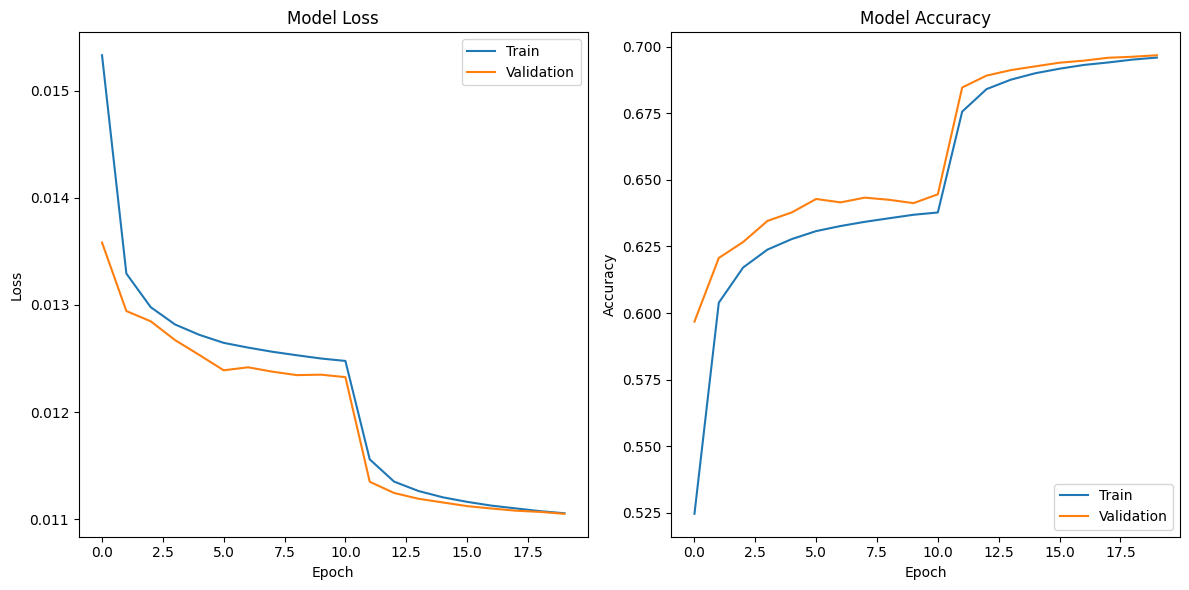

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
if val_loss:
    plt.plot(val_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_prec, label='Train')
if val_prec:
    plt.plot(val_prec, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Submission

In [31]:
tst = pd.read_parquet('/kaggle/input/leash-BELKA/test.parquet')
tst['binds'] = 0
tst.loc[tst['protein_name']=='BRD4', 'binds'] = preds[(tst['protein_name']=='BRD4').values, 0]
tst.loc[tst['protein_name']=='HSA', 'binds'] = preds[(tst['protein_name']=='HSA').values, 1]
tst.loc[tst['protein_name']=='sEH', 'binds'] = preds[(tst['protein_name']=='sEH').values, 2]
tst[['id', 'binds']].to_csv('submission.csv', index = False)